## Various kernel methods to calculate propensity scores


In [1]:
from sklearn import linear_model
from scipy.sparse import coo_matrix
from scipy.stats import ttest_rel, binom
from scipy.stats import chi2
import numpy as np
from math import log
import sys

import sklearn.metrics.pairwise
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
filename = "data/data1_movie_stopwords.txt"
param_reg = 1.0
param_thresh = 100000.0

word_docs = {}
docs_word = []
vocab = {}
l = 0

# part of documents we use
iter_num = 1000

for line in open(filename):
    if l >= iter_num:
        break
    tokens = line.strip().split()
    docs_word.append(tokens[1 : ])
    for word in set(tokens[1 : ]):
        if word not in vocab:
            vocab[word] = len(vocab)
        if word not in word_docs:
            word_docs[word] = []
        word_docs[word].append(l)
    
    l += 1
    
L = l
V = len(vocab)

print("%d documents, %d distinct word types" % (L, V))

1000 documents, 9114 distinct word types


In [3]:
vocab

{'10': 0,
 'great': 1,
 'words': 2,
 'known': 3,
 'gritty': 4,
 'renewed': 5,
 'plenty': 6,
 'blew': 7,
 'well': 8,
 'see': 9,
 'special': 10,
 'somehow': 11,
 'throughout': 12,
 'fast': 13,
 'hopefully': 14,
 'times': 15,
 'genuinely': 16,
 'acting': 17,
 'booked': 18,
 'faces': 19,
 'saw': 20,
 'already': 21,
 'love': 22,
 'felt': 23,
 'pattinson': 24,
 'movies': 25,
 'effects': 26,
 'story': 27,
 'even': 28,
 'eyebrow': 29,
 'awesome': 30,
 'franchise': 31,
 'raised': 32,
 'paced': 33,
 'away': 34,
 'cast': 35,
 'surprisingly': 36,
 'superhero': 37,
 'part': 38,
 'serkis': 39,
 'fan': 40,
 'play': 41,
 'film': 42,
 'andy': 43,
 'fantastic': 44,
 'exciting': 45,
 'admit': 46,
 'music': 47,
 'eat': 48,
 'robert': 49,
 'trying': 50,
 'matt': 51,
 'mostly': 52,
 'like': 53,
 'anticipated': 54,
 'really': 55,
 'way': 56,
 'knight': 57,
 'especially': 58,
 'paul': 59,
 'reeves': 60,
 'dano': 61,
 'movie': 62,
 'write': 63,
 'dark': 64,
 'batman': 65,
 'hurts': 66,
 'around': 67,
 'one': 6

In [4]:
word_docs

{'10': [0,
  7,
  8,
  17,
  19,
  27,
  29,
  57,
  59,
  63,
  71,
  105,
  106,
  112,
  119,
  120,
  125,
  130,
  140,
  145,
  150,
  156,
  171,
  182,
  185,
  194,
  200,
  204,
  206,
  211,
  212,
  213,
  224,
  225,
  228,
  237,
  241,
  255,
  270,
  273,
  276,
  279,
  280,
  291,
  297,
  303,
  304,
  308,
  328,
  336,
  337,
  338,
  343,
  348,
  349,
  364,
  373,
  392,
  397,
  402,
  411,
  414,
  420,
  423,
  441,
  455,
  457,
  465,
  468,
  477,
  494,
  503,
  527,
  566,
  578,
  580,
  582,
  586,
  615,
  619,
  637,
  654,
  655,
  671,
  674,
  685,
  693,
  697,
  703,
  714,
  718,
  733,
  735,
  751,
  760,
  768,
  770,
  771,
  784,
  801,
  804,
  810,
  811,
  820,
  831,
  838,
  840,
  864,
  876,
  886,
  891,
  900,
  903,
  909,
  916,
  923,
  934,
  944,
  947,
  952,
  964,
  968,
  970,
  971,
  991,
  992,
  994,
  997],
 'great': [0,
  1,
  2,
  3,
  7,
  8,
  12,
  17,
  22,
  24,
  28,
  29,
  37,
  38,
  49,
  50,
  52,
  54,


In [5]:
# I simpply chose a word for experiments.
treatment = "great"

rows = []
cols = []
values = []
y = []

for line in range(iter_num):

    contains_treatment = 0
    for word in docs_word[line]:
        if word == treatment:
            contains_treatment = 1
        else:
            rows.append(line)
            cols.append(vocab[word])
            values.append(1.0)
    y.append(contains_treatment)
    
x = coo_matrix((values, (rows, cols)), shape = (iter_num, V)).toarray()
print(x.shape)

(1000, 9114)


In [6]:
class Model(object):
    """
    This class uses svm with different kernel functions
    """
    def __init__(self, kernel = "linear", C = 1.0, gamma = 'auto', degree = 3, coef0 = 0., anova = False, percentile = 10):
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        self.anova = anova
        self.percentile = percentile
        # anova: of no use, just skip it
        if anova:
            self.model = Pipeline(
                [
                    ("anova", SelectPercentile()),
                    ("scaler", StandardScaler()),
                    ("svc", svm.SVC(kernel = self.kernel, C = self.C, gamma = self.gamma, 
                                    degree = self.degree, coef0 = self.coef0, probability = True))
                ]
            )
        else:
            self.model = svm.SVC(kernel = self.kernel, C = self.C, gamma = self.gamma, 
                                 degree = self.degree, coef0 = self.coef0, probability = True)
        
    def fit(self, x, y):
        self.model.fit(x, y)
        
    def predict_proba(self, x):
        return self.model.predict_proba(x)

In [7]:
## to plot histograms

def plt_hist(scores, y, coef = np.zeros((4, 2)), title = "Histogram", output = False):
    plt.figure(figsize=(15,7))
    plt.hist(scores[[i for i, x in zip(range(len(y)), y) if x == 0]], bins=50, label='Negatives')
    plt.hist(scores[[i for i, x in zip(range(len(y)), y) if x == 1]], bins=50, label='Positives', alpha = 0.7, color='r')
    plt.xlabel('Probability of being Positive Class', fontsize=25)
    plt.ylabel('Number of records in each bucket', fontsize=25)
    plt.legend(fontsize=15)
    plt.tick_params(axis='both', labelsize=25, pad=5)
    # to save the figure
    if output:
        coef_str = '_'.join('_'.join(str(int(x)) for x in line) for line in coef)
        if title != "Histogram":
            plt.title(title)
            imagepath = 'images/' + title + '.jpg'
        else:
            plt.title(coef_str)
            imagepath = 'images/coef' + coef_str + '.jpg'
        plt.savefig(imagepath)
    else:
        plt.show() 

## Logistic Regression

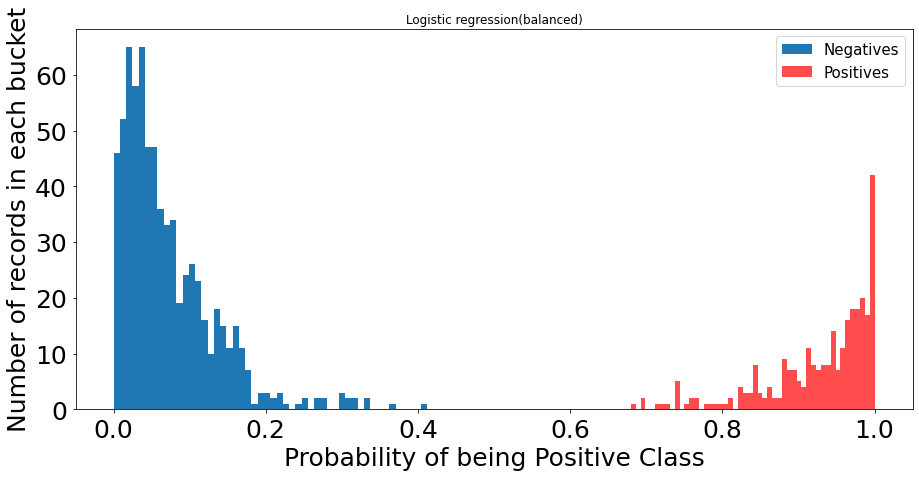

In [8]:
initial_model = linear_model.LogisticRegression(class_weight = 'balanced')
initial_model.fit(x, y)
initial_scores = initial_model.predict_proba(x)[ : , 1]
plt_hist(initial_scores, y, title = "Logistic regression(balanced)", output = True)

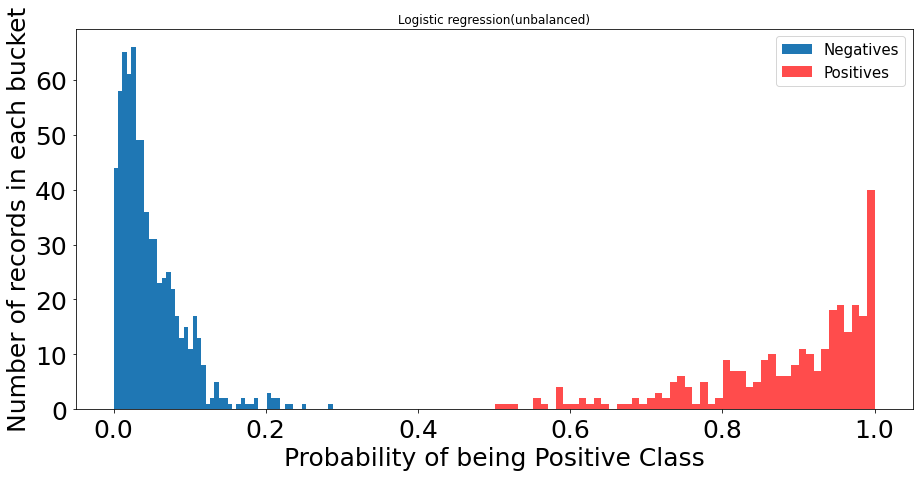

In [9]:
## Chosen
initial_model = linear_model.LogisticRegression()
initial_model.fit(x, y)
initial_scores = initial_model.predict_proba(x)[ : , 1]
plt_hist(initial_scores, y, title = "Logistic regression(unbalanced)", output = True)

## Hyperplane for unbalanced classes

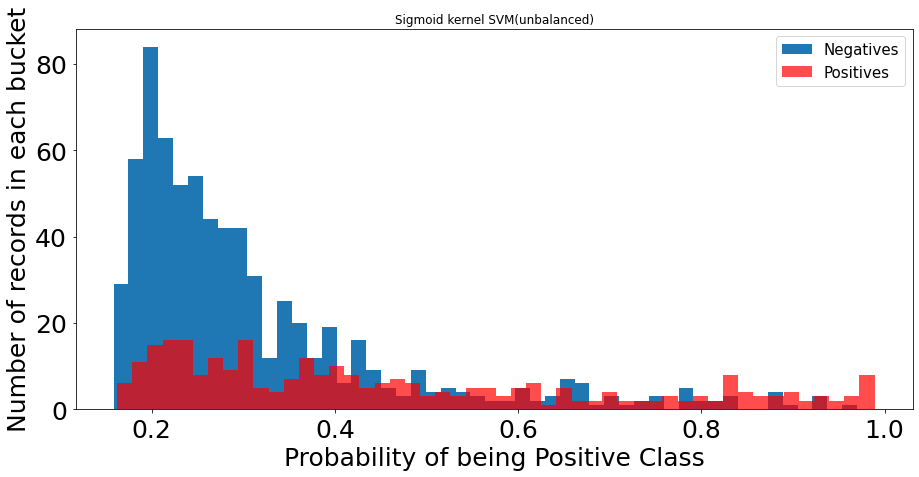

In [10]:
clf = svm.SVC(kernel = "sigmoid", C = 1, gamma = 0.001, degree = 2, coef0 = 10, probability = True)
clf.fit(x, y)
scores = clf.predict_proba(x)[ : , 1]
plt_hist(scores, y, title = "Sigmoid kernel SVM(unbalanced)", output = True)

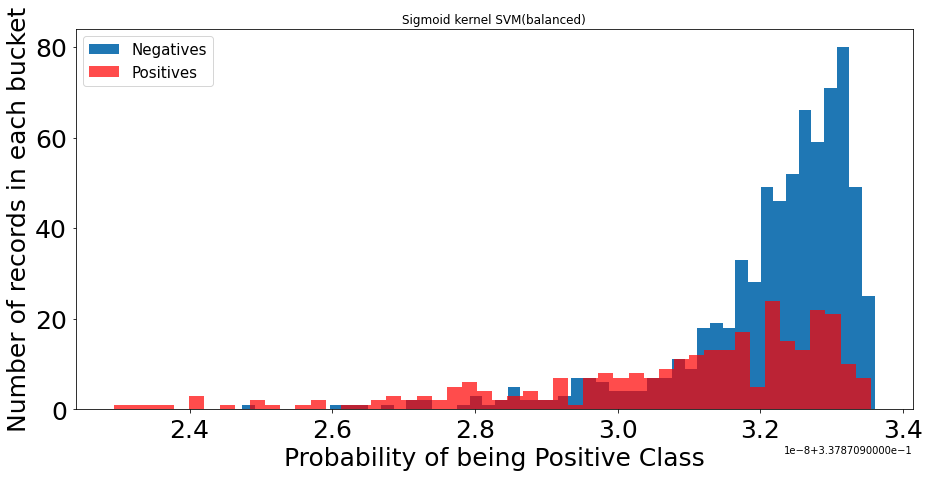

In [11]:
clf = svm.SVC(kernel = "sigmoid", C = 1, gamma = 0.001, degree = 2, coef0 = 10, probability = True, class_weight = 'balanced')
clf.fit(x, y)
scores = clf.predict_proba(x)[ : , 1]
plt_hist(scores, y, title = "Sigmoid kernel SVM(balanced)", output = True)

## Gaussian kernel

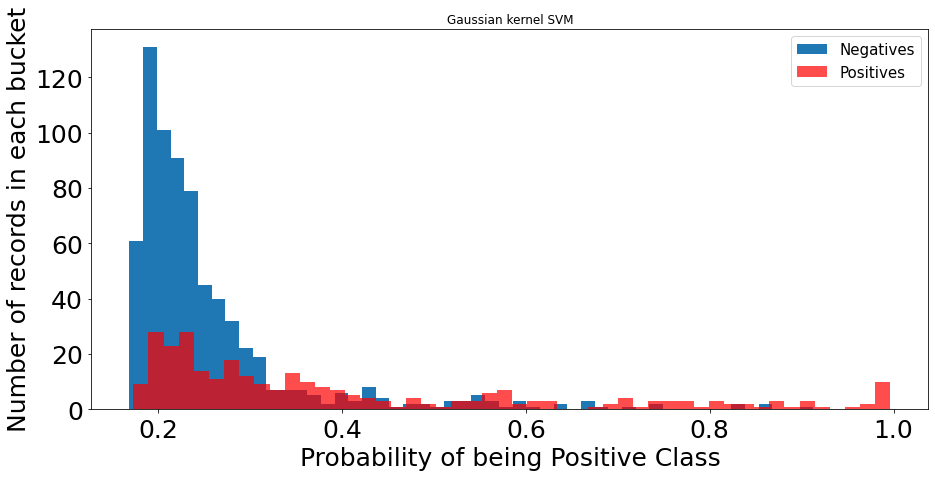

In [12]:
## Chosen
model = Model(kernel = 'rbf')
model.fit(x, y)
scores = model.predict_proba(x)[ : , 1]
plt_hist(scores, y, title = "Gaussian kernel SVM", output = True)

## Polynomial kernel (default: degree = 1)

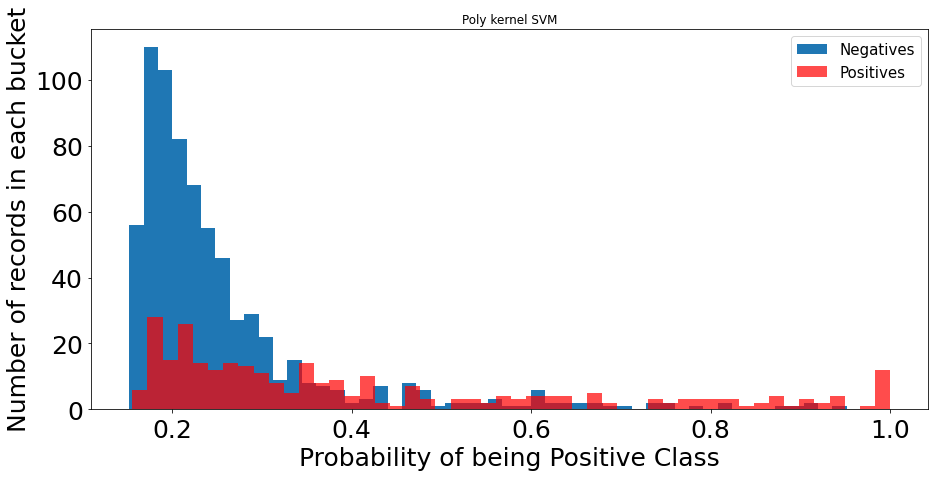

In [13]:
model = Model(kernel = 'poly', degree = 1)
model.fit(x, y)
scores = model.predict_proba(x)[ : , 1]
plt_hist(scores, y, title = "Poly kernel SVM", output = True)

## Sigmoid kernel

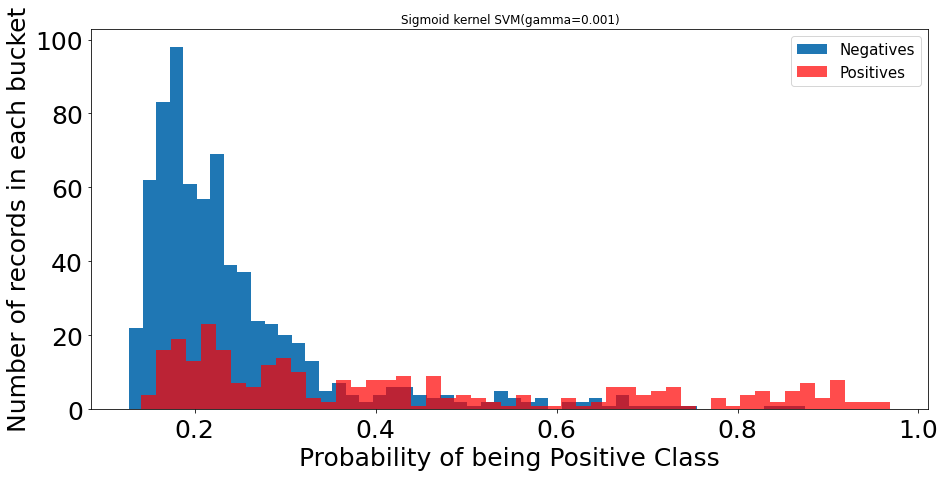

In [14]:
model = Model(kernel = 'sigmoid', gamma = 0.001)
model.fit(x, y)
scores = model.predict_proba(x)[ : , 1]
plt_hist(scores, y, title = "Sigmoid kernel SVM(gamma=0.001)", output = True)

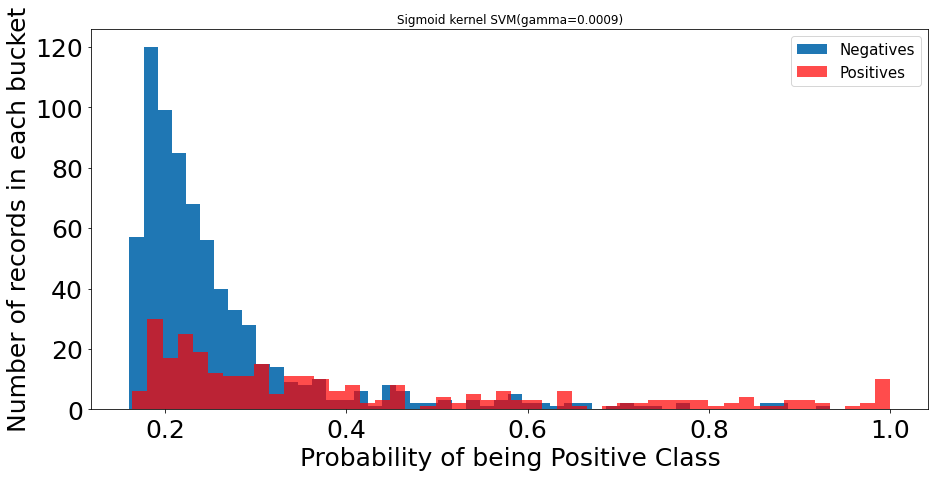

In [15]:
model = Model(kernel = 'sigmoid', gamma = 0.0001)
model.fit(x, y)
scores = model.predict_proba(x)[ : , 1]
plt_hist(scores, y, title = "Sigmoid kernel SVM(gamma=0.0009)", output = True)

## Linear kernel

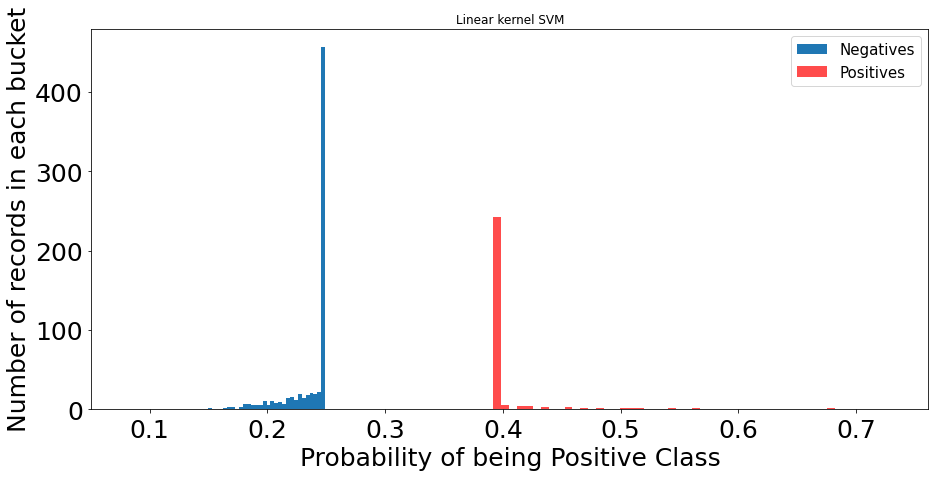

In [16]:
model = Model()
model.fit(x, y)
scores = model.predict_proba(x)[ : , 1]
plt_hist(scores, y, title = "Linear kernel SVM", output = True)

## Kernel methods with respect to LogisticRegression

### We calculate all kernel matrices we need here

In [17]:
x_rbf = sklearn.metrics.pairwise.rbf_kernel(x, x, gamma = 0.0015)
x_linear = sklearn.metrics.pairwise.linear_kernel(x, x)
x_poly = sklearn.metrics.pairwise.polynomial_kernel(x, x, degree = 2)
x_sigmoid = sklearn.metrics.pairwise.sigmoid_kernel(x, x, gamma = 0.0001)
x_additive_chi2 = sklearn.metrics.pairwise.additive_chi2_kernel(x, x)
x_chi2 = sklearn.metrics.pairwise.chi2_kernel(x, x, gamma = 1.)
x_laplacian = sklearn.metrics.pairwise.laplacian_kernel(x, x)

# LogisticRegression
model = linear_model.LogisticRegression(C=1)

## Gaussian kernel with LogisticRegression

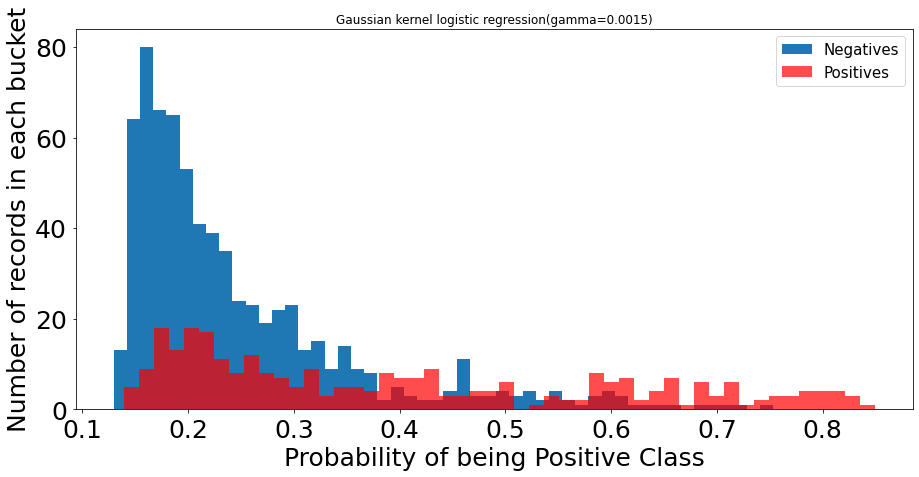

In [18]:
model.fit(x_rbf, y)
scores = model.predict_proba(x_rbf)[ : , 1]
plt_hist(scores, y, title = "Gaussian kernel logistic regression(gamma=0.0015)", output = True)

## Polynomial kernel with LogisticRegression

C:\Users\Fir\.conda\envs\d2l\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


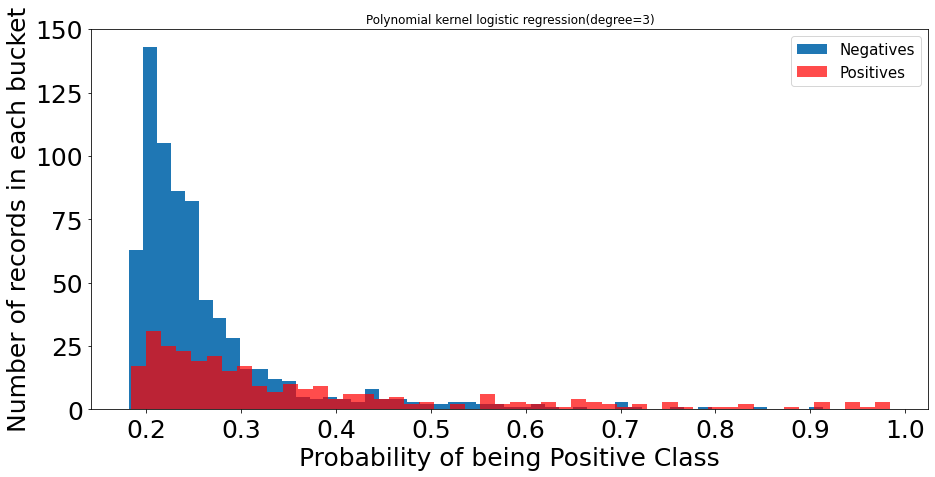

In [19]:
model.fit(x_poly, y)
scores = model.predict_proba(x_poly)[ : , 1]
plt_hist(scores, y, title = "Polynomial kernel logistic regression(degree=3)", output = True)

## Linear kernel with LogisticRegression

C:\Users\Fir\.conda\envs\d2l\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


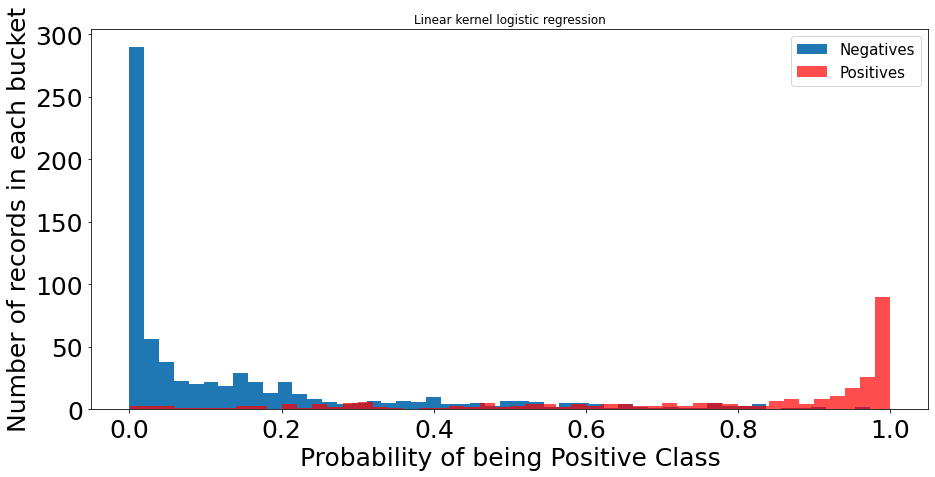

In [20]:
model.fit(x_linear, y)
scores = model.predict_proba(x_linear)[ : , 1]
plt_hist(scores, y, title = "Linear kernel logistic regression", output = True)

## Sigmoid kernel with LogisticRegression

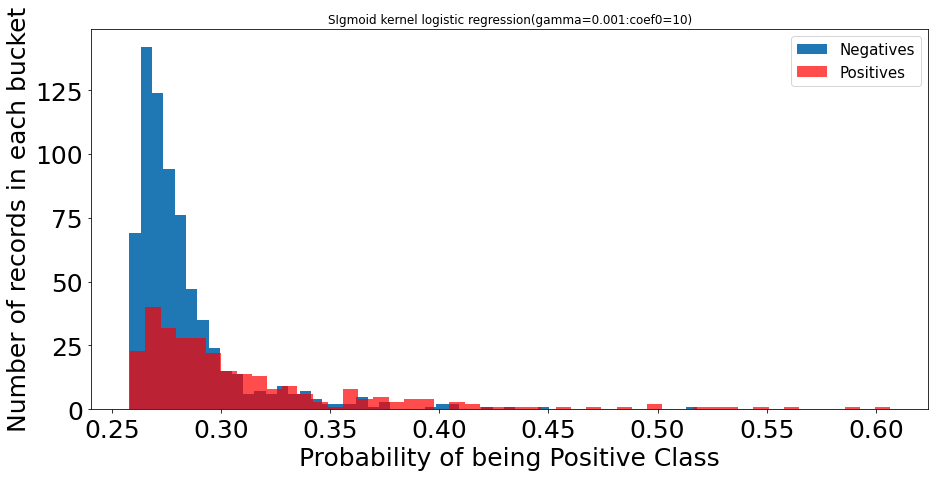

In [21]:
model.fit(x_sigmoid, y)
scores = model.predict_proba(x_sigmoid)[ : , 1]
plt_hist(scores, y, title = "SIgmoid kernel logistic regression(gamma=0.001:coef0=10)", output = True)

## Additive chi2 kernel LogisticRegression

C:\Users\Fir\.conda\envs\d2l\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


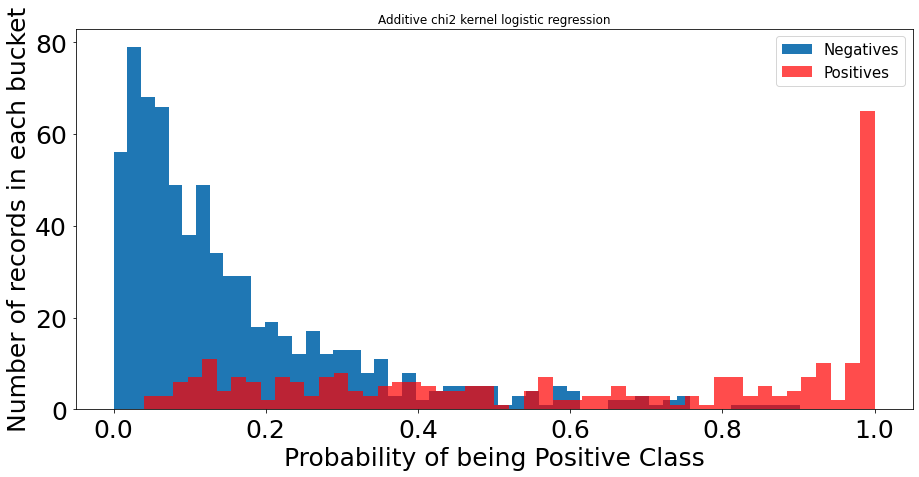

In [22]:
model.fit(x_additive_chi2, y)
scores = model.predict_proba(x_additive_chi2)[ : , 1]
plt_hist(scores, y, title = "Additive chi2 kernel logistic regression", output = True)

## Chi2 kernel LogisticRegression

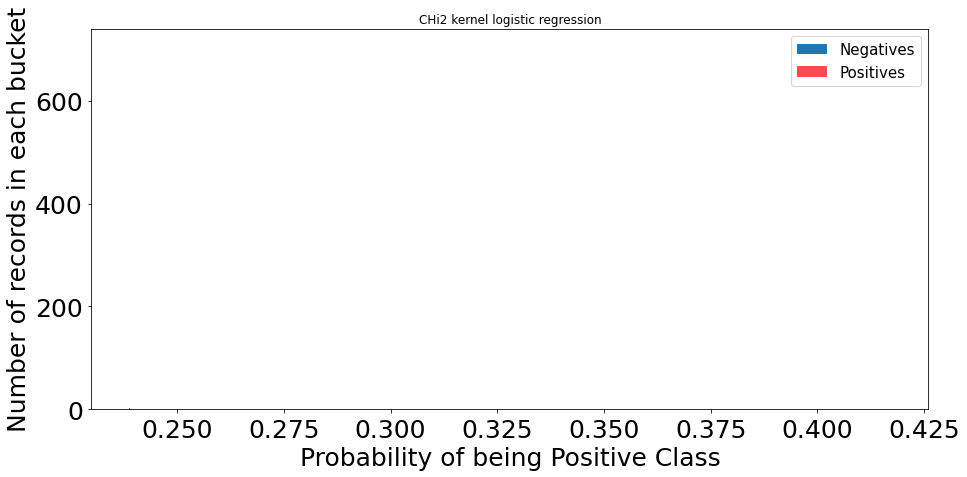

In [23]:
model.fit(x_chi2, y)
scores = model.predict_proba(x_chi2)[ : , 1]
plt_hist(scores, y, title = "CHi2 kernel logistic regression", output = True)

## Laplacian kernel LogisticRegression

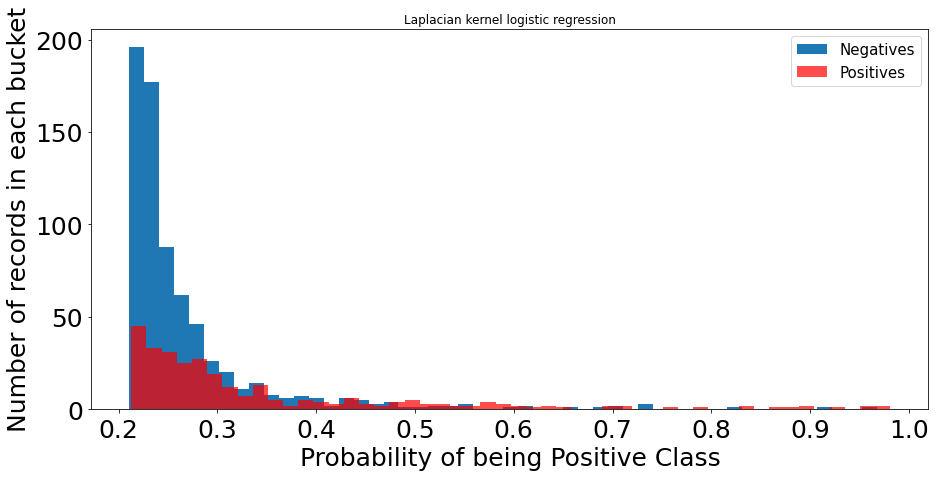

In [24]:
model.fit(x_laplacian, y)
scores = model.predict_proba(x_laplacian)[ : , 1]
plt_hist(scores, y, title = "Laplacian kernel logistic regression", output = True)

## Linear combination of various kernel functions

C:\Users\Fir\.conda\envs\d2l\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


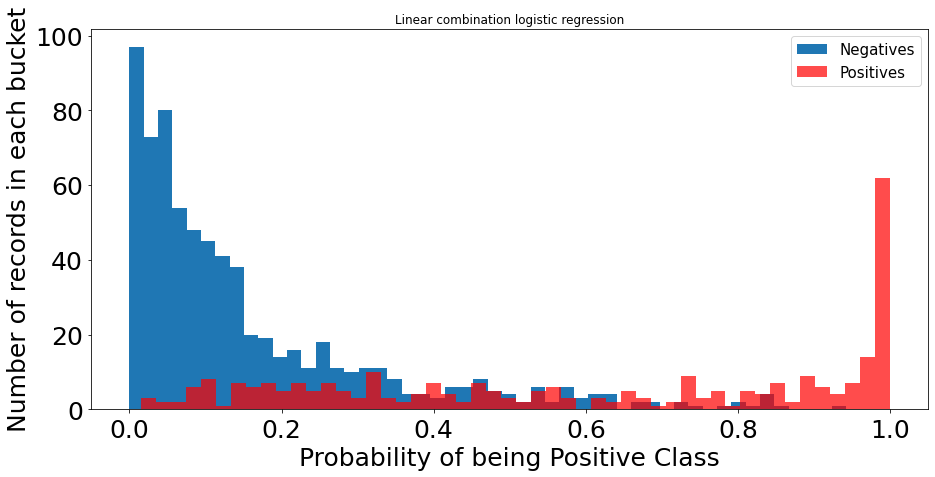

In [25]:
## Chosen
a = 1
b = 1
c = 1
d = 1
x_new = a * x_rbf + b * x_linear + c * x_poly + d * x_sigmoid
model.fit(x_new, y)
scores = model.predict_proba(x_new)[ : , 1]
plt_hist(scores, y, title = "Linear combination logistic regression", output = True)

C:\Users\Fir\.conda\envs\d2l\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


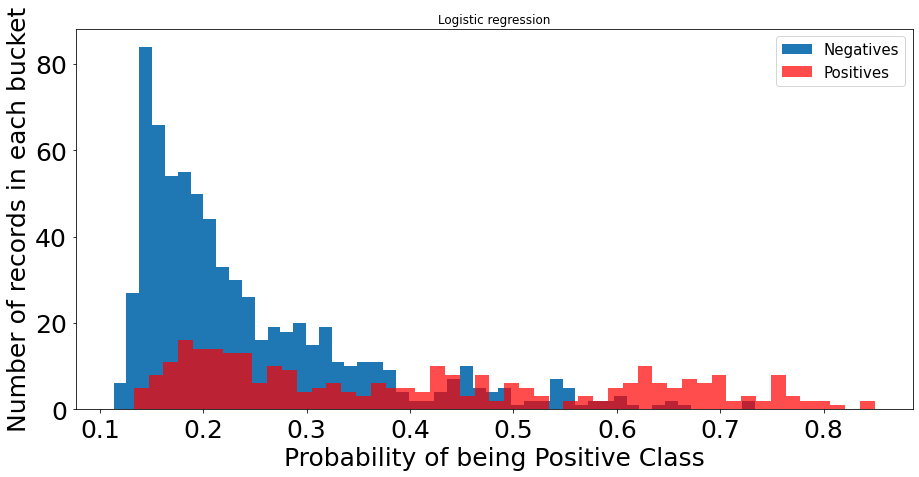

In [26]:
x_new = a * x_rbf ** 1.5
model.fit(x_new, y)
scores = model.predict_proba(x_new)[ : , 1]
plt_hist(scores, y, title = "Logistic regression", output = True)

In [27]:
# grid search for coefficients
# for a in range(1, 4):
#     for b in range(1, 4):
#         for c in range(1, 4):
#             for d in range(1, 4):
#                 for e in range(1, 4):
#                     for f in range(1, 4):
#                         for g in range(1, 4):
#                             for h in range(1, 4):
#                                 x_new = a * x_rbf ** b + c * x_linear ** d + e * x_poly ** f + g * x_sigmoid ** h
#                                 model.fit(x_new, y)
#                                 scores = model.predict_proba(x_new)[ : , 1]
#                                 coef = np.array([a, b, c, d, e, f, g, h]).reshape(4, 2)
#                                 plt_hist(scores, y, coef = coef, output = True)

## Logistic Regression (self-defined sigmoid function)

In [28]:
import scipy.stats

class LR(object):
    def __init__(self, learning_rate = 0.1, max_iter = 1000, seed = None, sigmoid_range = [0., 1.],beta = 1.0):
        self.seed = seed
        self.lr = learning_rate
        self.max_iter = max_iter
        self.sigmoid_range_l = sigmoid_range[0] if sigmoid_range[0] >= 0. and sigmoid_range[0] <= 1.0 else 0.
        self.sigmoid_range_r = sigmoid_range[1] if sigmoid_range[1] >= 0. and sigmoid_range[1] <= 1.0 else 1.
        self.beta = beta
        
    def fit(self, x, y):
        np.random.seed(self.seed)
        self.w = np.random.normal(loc = 0., scale = 1., size = x.shape[1])
        self.b = np.random.normal(loc = 0., scale = 1.)
        self.x = x
        self.y = y
        for i in range(self.max_iter):
            self.update()
            
    def update(self):
        dw, db = self.calc_gradient()
        self.w = self.w - self.lr * dw
        self.b = self.b - self.lr * db
        return self.w, self.b
    
    def calc_gradient(self):
        y_pred = self.predict()
        dw = (y_pred - self.y).dot(self.x) / len(self.y)
        db = np.mean(y_pred - self.y)
        return dw, db
    
    def predict(self, x = None):
        if x is None:
            x = self.x
        y_pred_proba = self.f(x, self.w, self.b)
        y_pred = np.array([1 if y_pred_proba[i] > 0.5 else 0 for i in range(len(y_pred_proba))])
        return y_pred
    
    def f(self, x, w, b):
        
        z = x.dot(w) + b
        sigmoid = self.sigmoid(z)
        distribution = np.array([[1 - sigmoid[i], sigmoid[i]] if self.y[i] else [sigmoid[i], 1 - sigmoid[i]] for i in range(len(sigmoid))])
        kl = np.array(scipy.stats.entropy(distribution, [1 / 2, 1 / 2], axis = 1))
        shift = np.array([kl[i] * (0.5 - sigmoid[i]) for i in range(len(sigmoid))])
        shift_ = np.array([0.5 - sigmoid[i] for i in range(len(sigmoid))])
        sigmoid += self.beta * shift
        return  (self.sigmoid_range_r - self.sigmoid_range_l) * sigmoid + self.sigmoid_range_l
    
    def sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))
    
    def predict_proba(self, x = None):
        if x is None:
            x = self.x
        y_pred = self.f(x, self.w, self.b)
        return y_pred
    
    def loss(self, y_true = None, y_pred_proba = None):
        if y_true is None or y_pred is None:
            y_true = self.y
            y_pred_proba = self.predict_proba()
        return np.mean(-1.0 * (y_true * np.log(y_pred_proba) + (1.0 - y_true) * np.log(1.0 - y_pred_proba)))

## Logistic regression from scratch

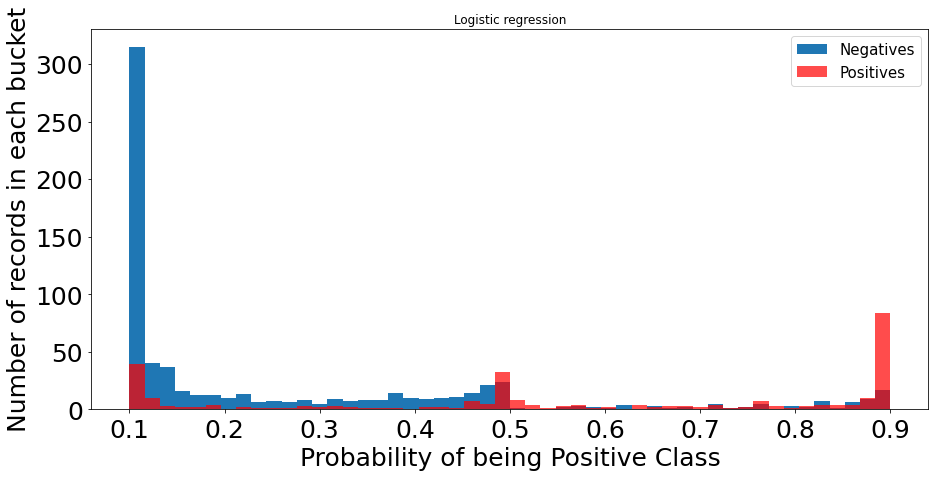

In [29]:
model = LR(max_iter = 1000, sigmoid_range = [0.1, 0.9], beta = .0)
model.fit(x, y)
scores = model.predict_proba(x)
plt_hist(scores, y, title = "Logistic regression", output = True)

## Add KL divergence (beta != 0)

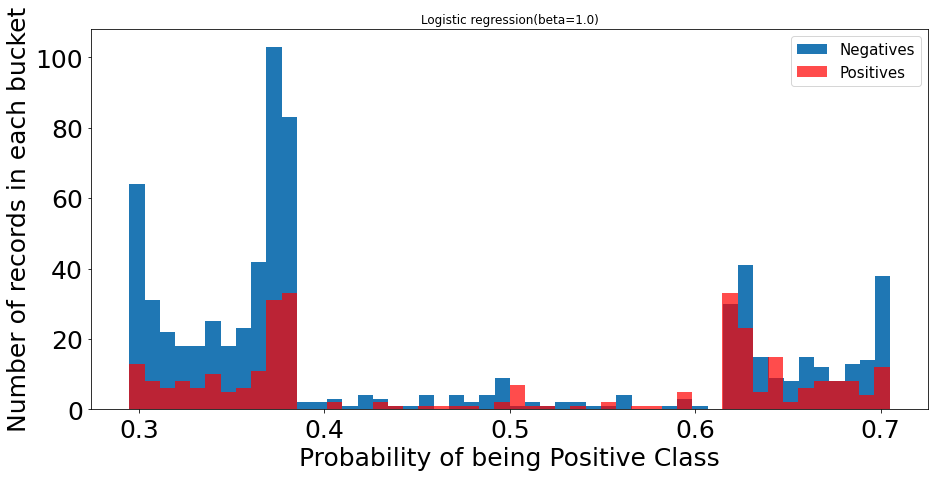

In [30]:
## Chosen
model = LR(max_iter = 200, sigmoid_range = [0.1, 0.9], beta = 1.)
model.fit(x, y)
scores = model.predict_proba(x)
plt_hist(scores, y, title = "Logistic regression(beta=1.0)", output = True)

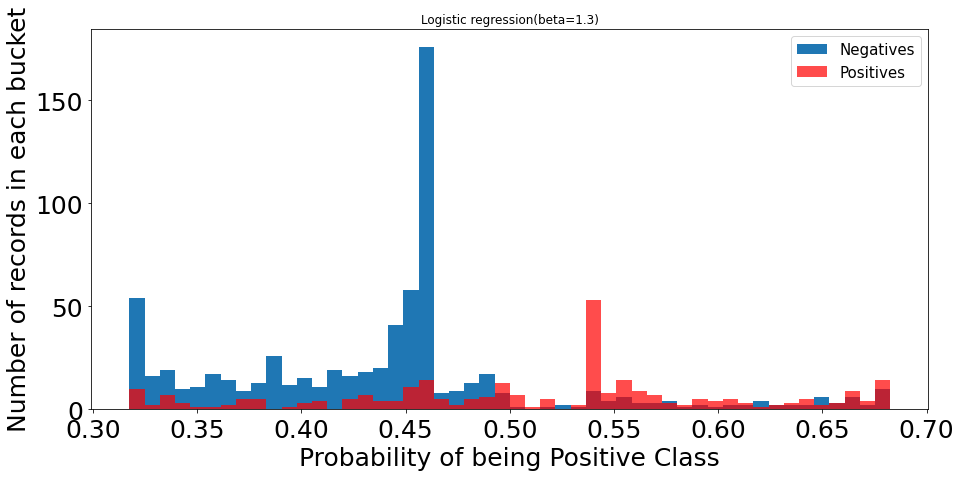

In [31]:
model = LR(max_iter = 1000, sigmoid_range = [0.1, 0.9], beta = 1.3)
model.fit(x, y)
scores = model.predict_proba(x)
plt_hist(scores, y, title = "Logistic regression(beta=1.3)", output = True)

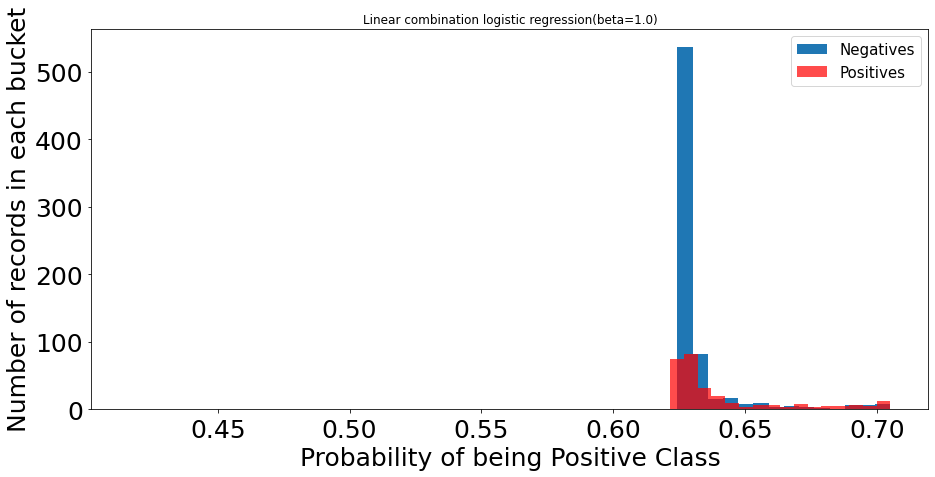

In [32]:
model = LR(max_iter = 100, sigmoid_range = [0.1, 0.9], beta = 1.0)
model.fit(x_new, y)
scores = model.predict_proba(x_new)
plt_hist(scores, y, title = "Linear combination logistic regression(beta=1.0)", output = True)

In [33]:
scipy.stats.entropy([[0.99, 0.01], [1 / 2, 1 / 2]], [0.01, 0.99], axis = 1)

array([4.50321745, 1.61446308])